In [24]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/toc3/temp-sr-press


In [25]:
from functools import partial
from xgboost import XGBClassifier
from gplearn.genetic import SymbolicClassifier

In [26]:
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.components import press
from express.visualization import plot_action
from express.utils import add_names
from express.features import state, pressure
import express.labels as ls

In [27]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f8ac8431eb0>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f8a6d45caf0>


In [28]:
dataset_train = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "train"))
dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))

print("dataset_train:", dataset_train)
print("dataset_test:", dataset_test)

dataset_train: functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/temp-sr-press/stores/datasets/train')
dataset_test: functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/temp-sr-press/stores/datasets/test')


In [29]:
train_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "train"),
    state_xfns=state.all_features,
    pressure_xfns={"pressure_state_xfns": pressure.pressure_state_features,
                    "pressure_with_context_xfns": pressure.pressure_with_context_features},
    yfns=[f.__name__ for f in ls.all_labels],
    load_cached =True,
    nb_prev_actions = 3,
)

test_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "test"),
    state_xfns=state.all_features,
    pressure_xfns={"pressure_state_xfns": pressure.pressure_state_features,
                    "pressure_with_context_xfns": pressure.pressure_with_context_features},
    yfns=[f.__name__ for f in ls.all_labels],
    load_cached =True,
    nb_prev_actions = 3,
)

In [30]:
model = "xgboost" #"soccermap"
trial = 0
save_path = os.path.join(base_path, "stores", "model", model, f"{trial:03d}", "component.pkl")
save_path

'/home/toc3/temp-sr-press/stores/model/xgboost/000/component.pkl'

In [31]:
from express.components.base import exPressComponent
import pickle
from pathlib import Path

path = Path(save_path)
component = pickle.load(path.open(mode="rb"))
component

In [32]:
component.test(dataset_train)

{'precision': 0.9137104506232023,
 'recall': 0.7289117132867133,
 'f1': 0.8109159423813287,
 'log_loss': 0.2953825980711059,
 'brier': 0.08545622602971567,
 'roc_auc': 0.9449820265485651}

In [33]:
component.test(dataset_test)

{'precision': 0.73370738023306,
 'recall': 0.5007363770250368,
 'f1': 0.5952380952380952,
 'log_loss': 0.5116785542534759,
 'brier': 0.16515970351029532,
 'roc_auc': 0.7946908333055114}

In [34]:
preds = component.predict(dataset_test)

In [12]:
train_dataset.features

actiontype_a0 actiontype_a1     actiontype_a2 result_a0  \
game_id action_id                                                           
3788741 2                  pass       dribble              pass   success   
        18                 pass       dribble              pass      fail   
        26                 pass      throw_in            tackle   success   
        30              dribble     bad_touch           dribble   success   
        33              dribble          pass           dribble   success   
...                         ...           ...               ...       ...   
3943043 2157               pass          pass           dribble   success   
        2167            dribble          pass              pass   success   
        2182           throw_in      goalkick              shot   success   
        2185           throw_in          pass          throw_in   success   
        2206            dribble     clearance  freekick_crossed   success   

                  result_a1 result_a2 bodypart_a0 bodypart_a1 bodypart_a2  \
game_id action_id                                                           
3788741 2           success   success        foot        foot        foot   
        18          success   success        foot        foot        foot   
        26          success      fail        foot       other        foot   
        30             fail   success        foot        foot        foot   
        33          success   success        foot        foot        foot   
...                     ...       ...         ...         ...         ...   
3943043 2157        success   success        foot        foot        foot   
        2167           fail      fail        foot        foot        foot   
        2182           fail      fail       other        foot        head   
        2185           fail   success       other        foot       other   
        2206        success      fail        foot        head        foot   

                   period_id_a0  ...  opponent_10_y_p0  \
game_id action_id                ...                     
3788741 2                     1  ...               NaN   
        18                    1  ...               NaN   
        26                    1  ...               NaN   
        30                    1  ...               NaN   
        33                    1  ...               NaN   
...                         ...  ...               ...   
3943043 2157                  2  ...               NaN   
        2167                  2  ...               NaN   
        2182                  2  ...               NaN   
        2185                  2  ...               NaN   
        2206                  2  ...         29.847266   

                   opponent_10_distance_p0  opponent_11_x_p0  \
game_id action_id                                              
3788741 2                              NaN               NaN   
        18                             NaN               NaN   
        26                             NaN               NaN   
        30                             NaN               NaN   
        33                             NaN               NaN   
...                                    ...               ...   
3943043 2157                           NaN               NaN   
        2167                           NaN               NaN   
        2182                           NaN               NaN   
        2185                           NaN               NaN   
        2206                     34.477067               NaN   

                   opponent_11_y_p0  opponent_11_distance_p0    dx_p0   dy_p0  \
game_id action_id                                                               
3788741 2                       NaN                      NaN  19.6875 -57.290   
        18                      NaN                      NaN   2.3625  -3.910   
        26                      NaN                      NaN  53.3750  43.690   
        30           

779 771 1006
(3869685, 1004)
(3869685, 1005)
(3869685, 1006)
(3869685, 1007)


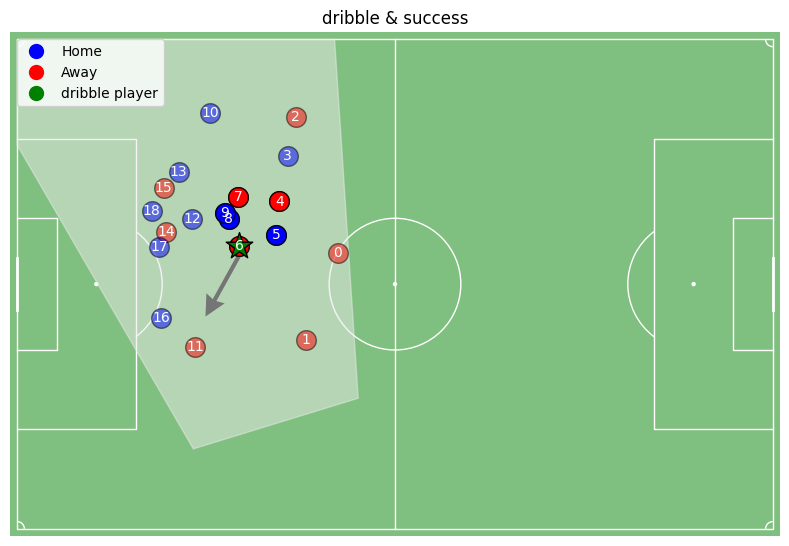

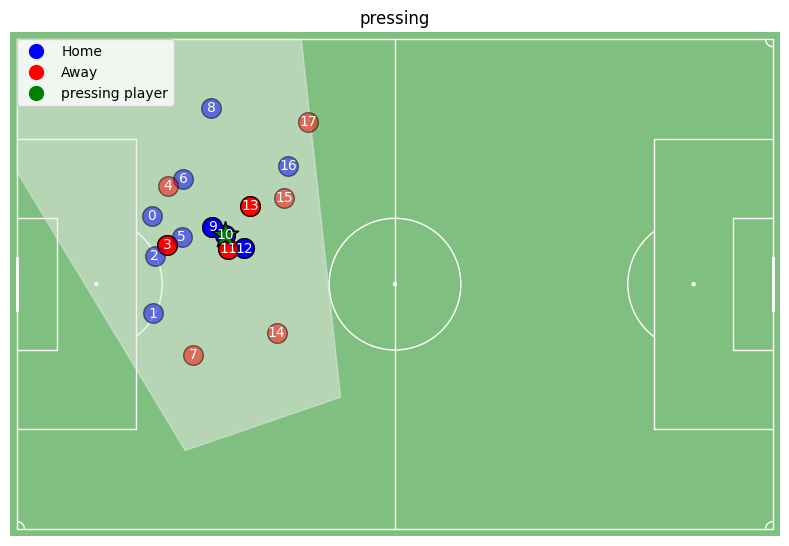

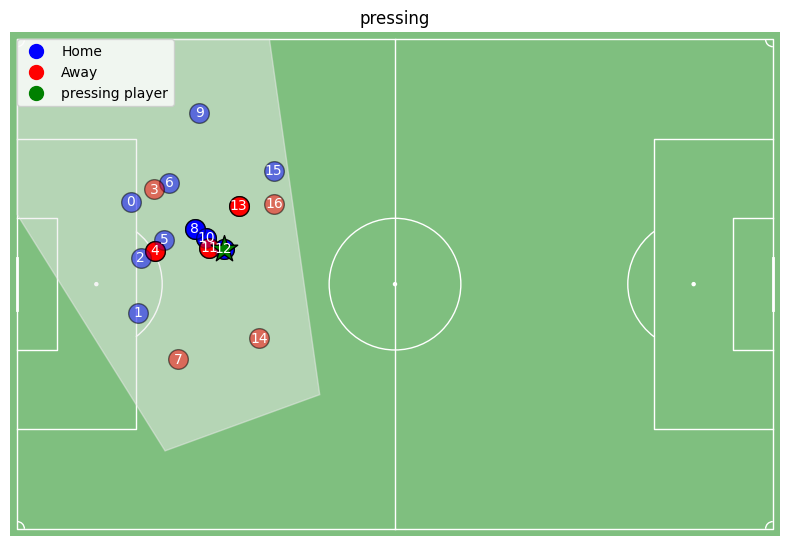

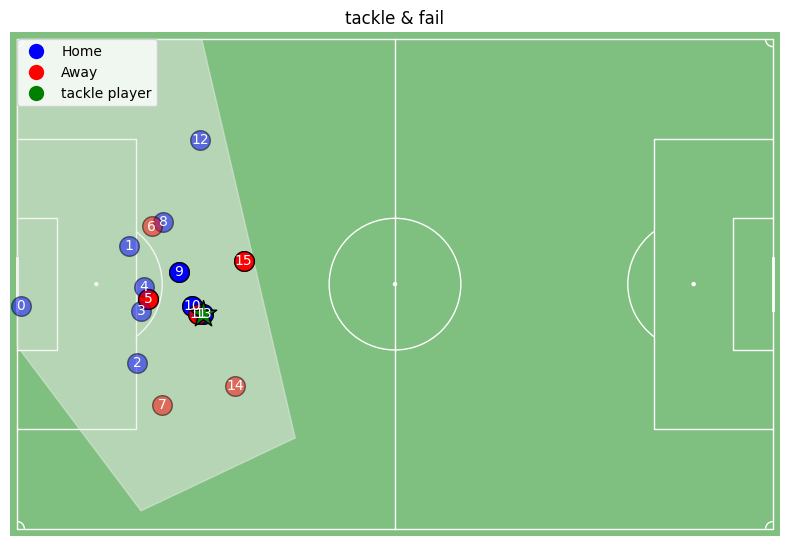

In [21]:
game_id = 3869685

df_actions = add_names(test_db.actions(game_id)).reset_index()

pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[99]
home_team_id, away_team_id = test_db.get_home_away_team_id(game_id = game_id)

print(home_team_id, away_team_id, pressure_idx)

for idx in range(pressure_idx-2, pressure_idx+2):
    action_id = df_actions.at[idx, "action_id"]
    print((game_id,action_id))
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame:",idx)
        plot_action(df_actions.loc[idx], home_team_id=home_team_id, show_visible_area=False)
    else:
        try:
            # plot_action: 데이터의 위치 정보는 홈팀은 left->right, 원정팀은 left<-right인 상태이다.
            plot_action(df_actions.loc[idx], home_team_id=home_team_id, prob=preds.loc[(game_id, action_id)].iloc[0])
        except:
            plot_action(df_actions.loc[idx], home_team_id=home_team_id, prob=None)

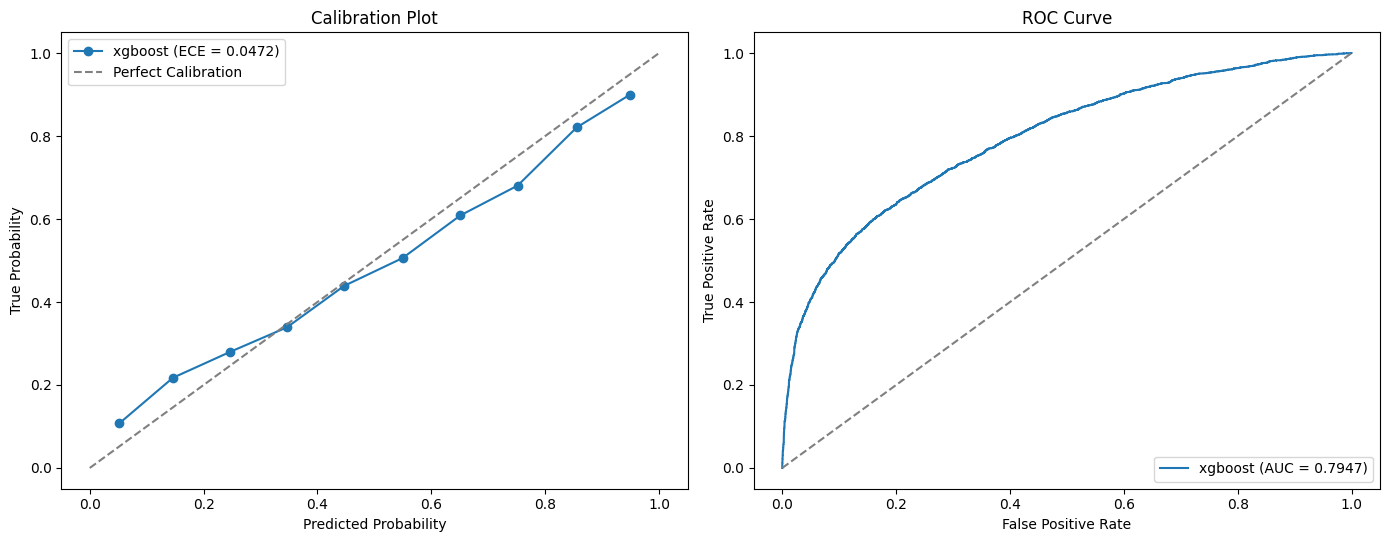

In [35]:
import torch
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, roc_auc_score
from torchmetrics.classification import BinaryCalibrationError

def plot_calibration_curves(y_true, y_pred, ax):
    bce_l1 = BinaryCalibrationError(n_bins=10, norm='l1')
    ece = bce_l1(torch.Tensor(y_pred), torch.Tensor(y_true))

    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', label=f'{model} (ECE = {ece:.4f})')

    ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Perfect Calibration')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('True Probability')
    ax.set_title('Calibration Plot')
    ax.legend()

def plot_roc_curves(y_true, y_pred, ax):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    ax.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.4f})')

    ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='lower right')

label_column = "possession_change_by_4_actions"#"possession_change_by_4_actions_and_5m_distance"
y_pred = component.predict(dataset_test)[label_column].values
y_true = test_dataset.labels[label_column].values

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_calibration_curves(y_true, y_pred, axes[0])
plot_roc_curves(y_true, y_pred, axes[1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### XGBoost feature importances

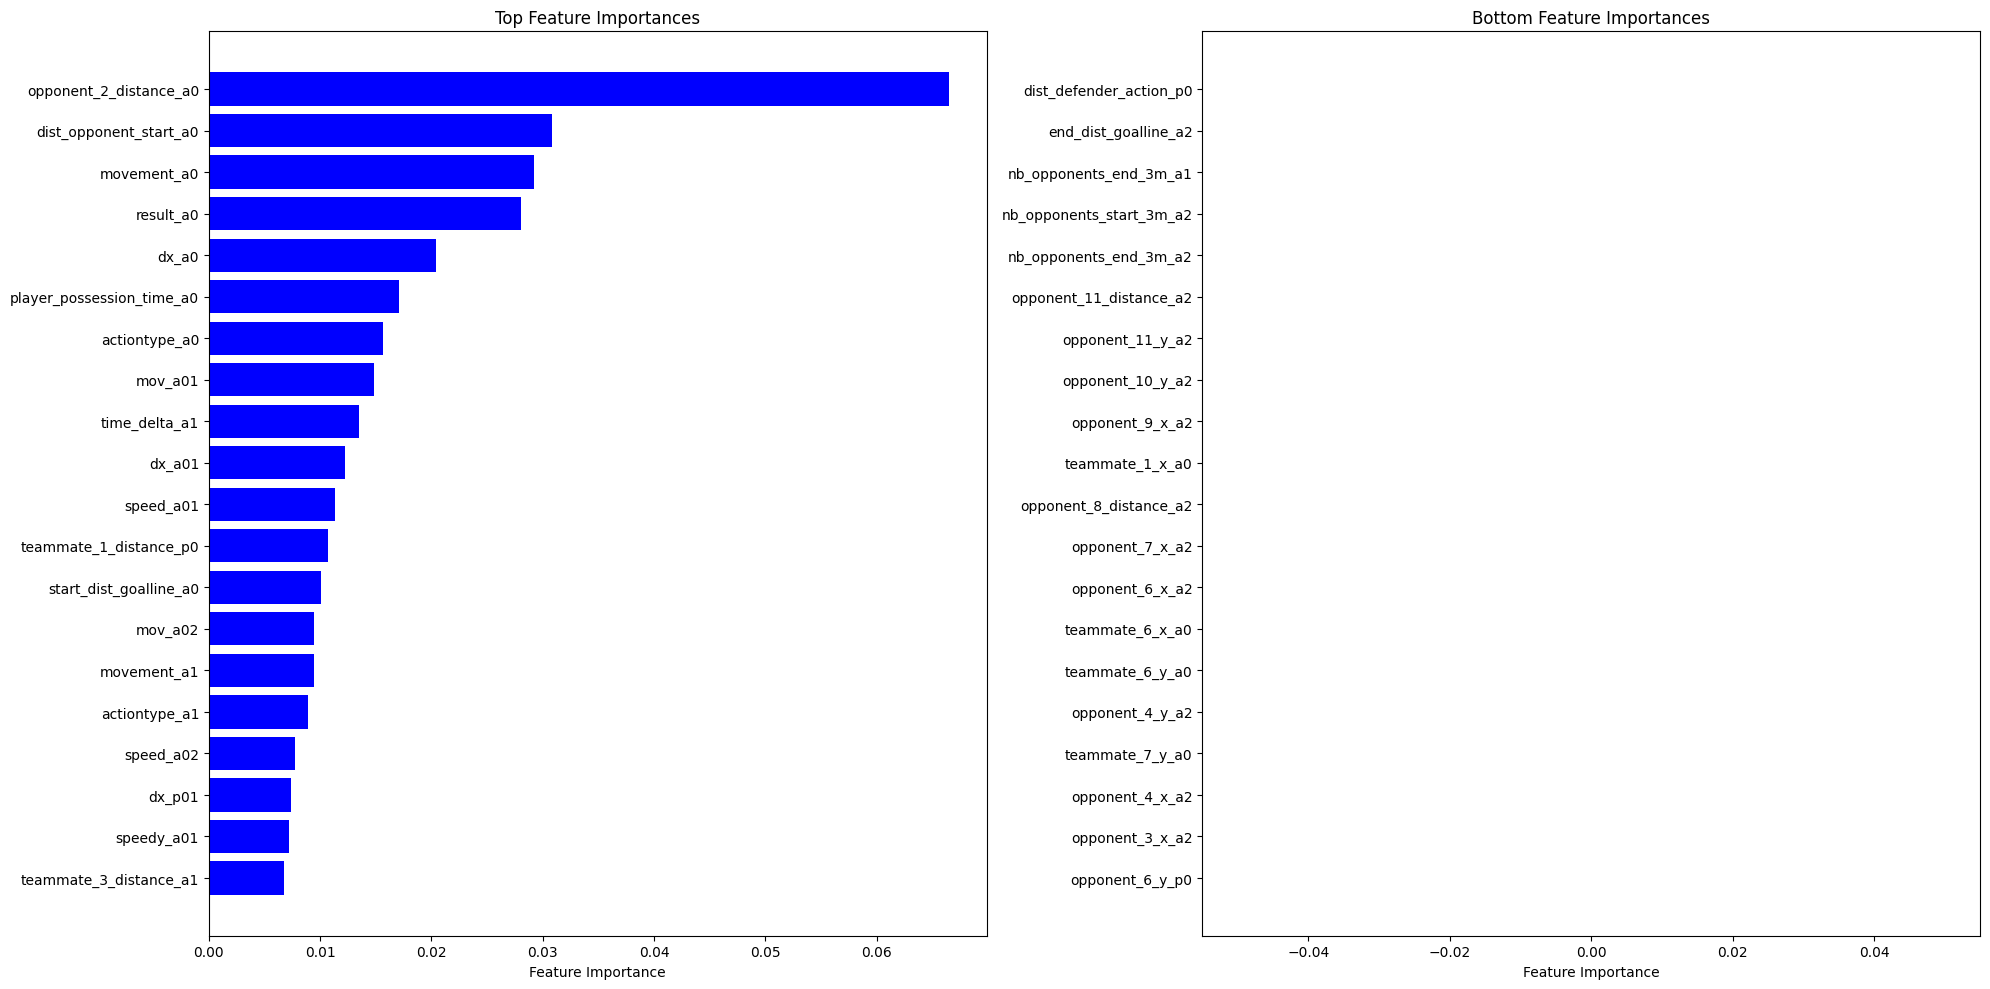

In [23]:
import numpy as np
import matplotlib.pyplot as plt

k = 20  # 원하는 k 값을 설정하세요 (상위 및 하위 k개)

state_features = [col for _, cols in component.state_features.items() for col in cols]
pressure_state_features = [col for _, cols in component.pressure_features["pressure_state_xfns"].items() for col in cols]
pressure_with_context_features = [col for _, cols in component.pressure_features["pressure_with_context_xfns"].items() for col in cols]
features = state_features + pressure_state_features + pressure_with_context_features
importances = component.model.feature_importances_

# 상위 k개와 하위 k개 피처 인덱스 선택
top_indices = np.argsort(importances)[-k:]  # 상위 k개의 인덱스
bottom_indices = np.argsort(importances)[:k]  # 하위 k개의 인덱스

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 왼쪽: 상위 k개
axes[0].barh(range(k), importances[top_indices], align='center', color='blue')
axes[0].set_yticks(range(k))
axes[0].set_yticklabels([features[i] for i in top_indices])
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Top Feature Importances')

# 오른쪽: 하위 k개
axes[1].barh(range(k), importances[bottom_indices], align='center', color='red')
axes[1].set_yticks(range(k))
axes[1].set_yticklabels([features[i] for i in bottom_indices])
axes[1].set_xlabel('Feature Importance')
axes[1].set_title('Bottom Feature Importances')

plt.tight_layout()
plt.show()


In [13]:
game_id = 3895302

df_actions = add_names(train_db.actions(game_id)).reset_index()
df_actions.head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3895302,0,221b0c8d-6386-4ae8-bb4a-a1dc98742312,1,3.417,176,34870,52.0625,33.660,53.8125,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 12299, 'name': '...",None,0,None,pass,success,foot_right
1,3895302,1,77809242-1460-4395-8779-94a0cfc275b1,1,3.870,176,12299,53.8125,34.340,53.8125,...,176.0,From Kick Off,0,"{'carry': {'end_location': [59.0, 40.6]}}",None,0,None,dribble,success,foot
2,3895302,2,ff56e821-21e9-4cef-ba2a-7eb5eb3769c6,1,4.732,176,12299,53.8125,34.085,74.7250,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 31100, 'name': '...","[[90.44126933110154, 68.0], [67.695055809645, ...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right
3,3895302,3,cf9088bc-7e59-4d57-8ac5-31658da858bb,1,6.728,176,31100,74.7250,36.295,74.7250,...,176.0,From Kick Off,0,"{'carry': {'end_location': [35.1, 43.7]}}","[[94.70003623525969, 68.0], [70.82236198763701...",1,"[{'teammate': True, 'actor': True, 'keeper': F...",dribble,success,foot
4,3895302,4,4464cb75-f45f-4508-8444-2560d1625d06,1,7.622,176,31100,74.7250,36.720,76.3875,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 51769, 'name': '...","[[96.23592025888192, 68.0], [71.95638033011264...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right


### Visualization

Skip action due to missing freeze frame


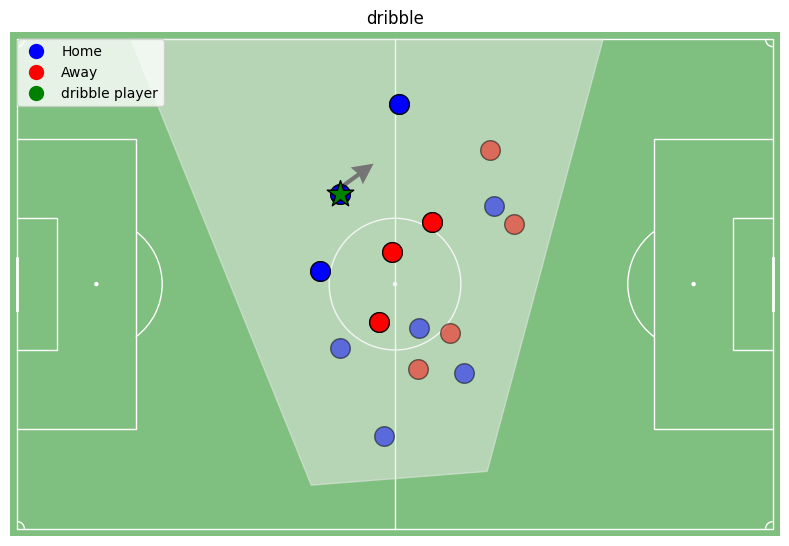

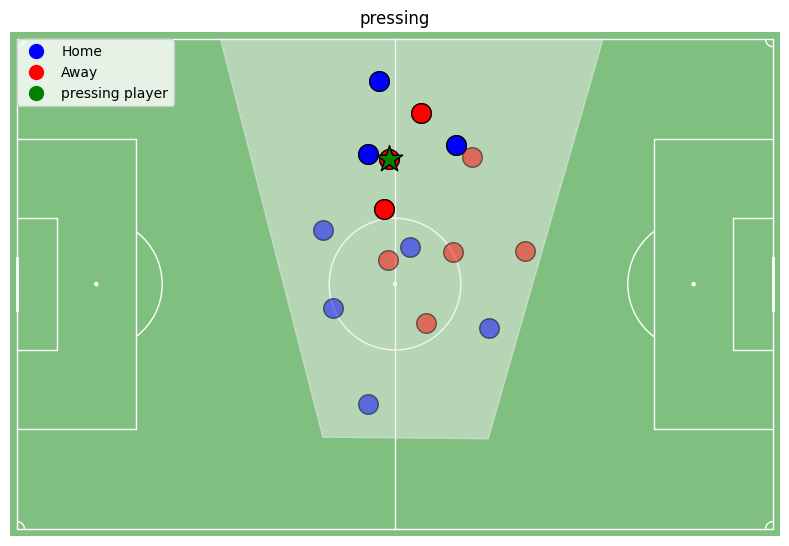

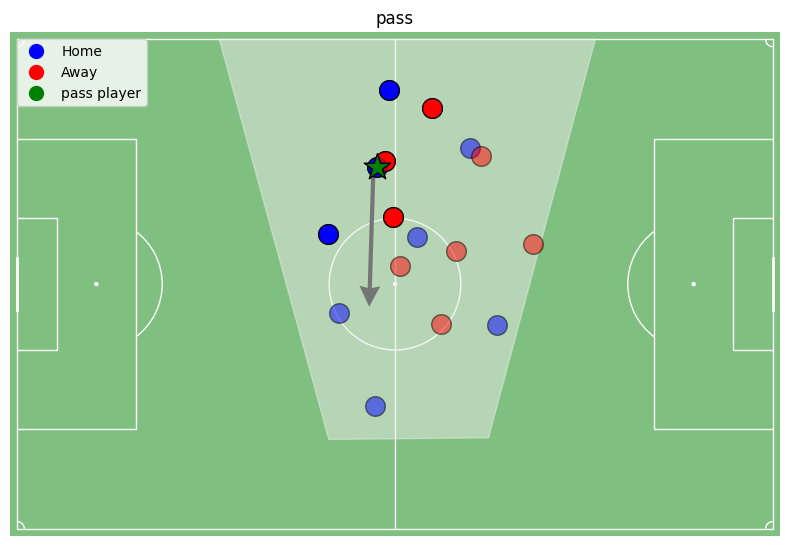

In [14]:
pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[5]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = 3895302)
for idx in range(pressure_idx-2, pressure_idx+2):
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame")
        continue
    plot_action(df_actions.loc[idx], home_team_id=home_team_id)